In [1]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
%matplotlib inline
from scipy import stats
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [3]:
model_vars_data = pd.read_csv(r'C:\Users\dgarb\OneDrive\Documents\Data Science Bootcamp August\Machine Learning Project\data\model_vars_data_n.csv',index_col=0)

test_vars_data = pd.read_csv(r'C:\Users\dgarb\OneDrive\Documents\Data Science Bootcamp August\Machine Learning Project\data\test_vars_data_n.csv',index_col=0)

price_train = pd.read_csv(r'C:\Users\dgarb\OneDrive\Documents\Data Science Bootcamp August\Machine Learning Project\data\ny_train.csv',index_col=0)

price_test = pd.read_csv(r'C:\Users\dgarb\OneDrive\Documents\Data Science Bootcamp August\Machine Learning Project\data\ny_test.csv',index_col=0)

In [4]:
# Fucntion returns dictionary

def regx3(
model=  None,
x_train = None,
x_test = None,
y_train = None,
y_test =  None,
params = None,
cv_ = 5,
linear_reg = True,
tree_based = False):
######################################
#########################################

    features = list(x_train.columns)

    ss = StandardScaler()
    x_train = pd.DataFrame(ss.fit_transform(x_train), columns = features)
    x_test = pd.DataFrame(ss.fit_transform(x_test), columns = features)

    #     print('train ',x_train.head())
    #     print(' ')
    #     print('test ', x_test.head())


    gs = GridSearchCV(model, params, cv=cv_, return_train_score=True, refit=True)
    gs.fit(x_train,y_train)
    gs.best_params_

    reg_dict = {}
    model= gs.best_estimator_
    reg_dict['mod'] = model
    ###################################    

    print('best params: ',gs.best_params_)
    reg_dict['best params'] = gs.best_params_

    print('score: ',gs.score(x_train,y_train))
    reg_dict['score'] = gs.score(x_train,y_train)

    print('  ')
    print('test score: ',gs.score(x_test,y_test))
    reg_dict['test score'] = gs.score(x_test,y_test)

    if linear_reg:
        adj_r2 = 1-(1-gs.score(x_train,y_train))*(x_train.shape[0] - 1) / (x_train.shape[0] - x_train.shape[1] - 1)
        print('adj_r2: ', adj_r2)
        reg_dict['adj_r2'] = adj_r2

        adj_r2_test = 1-(1-gs.score(x_test,y_test))*(x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1)
        print('  ')
        print('adj_r2_test: ',adj_r2_test)
        reg_dict['adj_r2_test'] = adj_r2_test

        print(' ')

    train_pred = gs.best_estimator_.predict(x_train)
    print('train RMSE: ' + str(mean_squared_error(train_pred,y_train)**0.5))
    print('  ')
    reg_dict['train RMSE'] = mean_squared_error(train_pred,y_train)**0.5

    test_pred = gs.best_estimator_.predict(x_test)
    print('test RMSE: ' + str(mean_squared_error(test_pred,y_test)**0.5))
    ###
    reg_dict['test RMSE'] = mean_squared_error(test_pred,y_test)**0.5

    if linear_reg:

        coefs = pd.Series(gs.best_estimator_.coef_, name = 'coef' )

        varnames = pd.Series(features, name = 'features')

        pd.set_option('display.max_rows', None) # or 1000.

        abs_coefs = pd.Series(np.abs(coefs),name = 'abs_val')

        coefs_ = pd.concat([varnames,coefs, abs_coefs], axis=1)

        #return:
        model_importances = coefs_.sort_values(by=['abs_val'], ascending=False)
        model_importances.index=(range(model_importances.shape[0]))
        model_importances
        reg_dict['model_importances'] = model_importances

        print(model_importances)
        print(' ')

    elif tree_based:
        pd.set_option('display.max_rows', None) # or 1000.

        #return
        varnames = pd.Series(features, name = 'features')

        importances_ = pd.Series(model.feature_importances_, name = 'importances')

        df = pd.concat([varnames,importances_], axis=1)

        model_importances = df.sort_values(by=['importances'], ascending=False)

        model_importances.index=(range(model_importances.shape[0]))

        reg_dict['model_importances'] = model_importances



    #         model_importances = pd.Series(model.feature_importances_, index = features).sort_values(ascending=False)

        print(model_importances)


    if linear_reg:
        residuals = y_train - train_pred
        print('skewness: ',stats.skew(residuals))
        print(' ')
        sns.set_theme(style='darkgrid')
        sns.histplot(residuals, bins=20);

    print('model_importances.shape: ',model_importances.shape)
    
    return reg_dict


best params:  {'alpha': 0.001, 'tol': 0.02}
score:  0.9515858667400429
  
test score:  0.9261959575269095
adj_r2:  0.9451224414478681
  
adj_r2_test:  0.898219695939637
 
train RMSE: 0.08305439467648044
  
test RMSE: 0.10125008792633103
                                              features      coef   abs_val
0                                         bc_GrLivArea  0.097538  0.097538
1                                           BsmtFinSF1  0.089108  0.089108
2                                          OverallQual  0.060374  0.060374
3                                            BsmtUnfSF  0.053855  0.053855
4                                          OverallCond  0.047998  0.047998
5                                           house_age_ -0.038773  0.038773
6                                             2ndFlrSF  0.038427  0.038427
7                                           BsmtFinSF2  0.035822  0.035822
8                                           bc_LotArea  0.032298  0.032298
9            

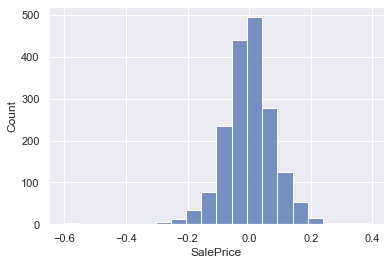

In [5]:
elas1 = regx3(model= ElasticNet(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data,
x_test = test_vars_data,
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,100],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)

<AxesSubplot:ylabel='Density'>

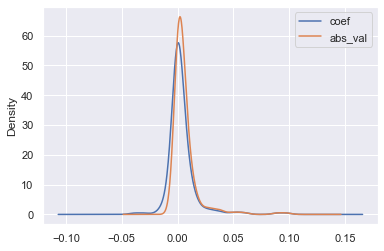

In [7]:
elas1['model_importances'].plot.kde()

<AxesSubplot:ylabel='Density'>

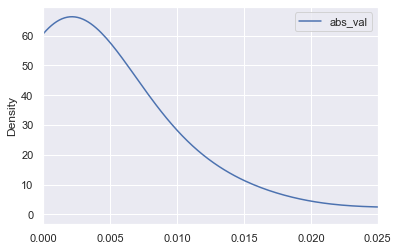

In [12]:
elas1['model_importances'].plot.kde(y='abs_val',xlim=[0.0,0.025]) 

based on graph below, drop features with coefficients less than 0.002

<AxesSubplot:ylabel='Density'>

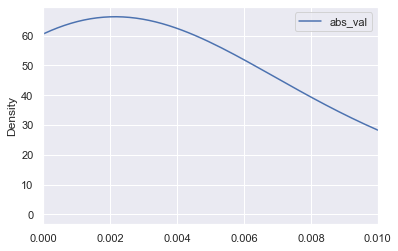

In [13]:
elas1['model_importances'].plot.kde(y='abs_val',xlim=[0.0,0.010]) 